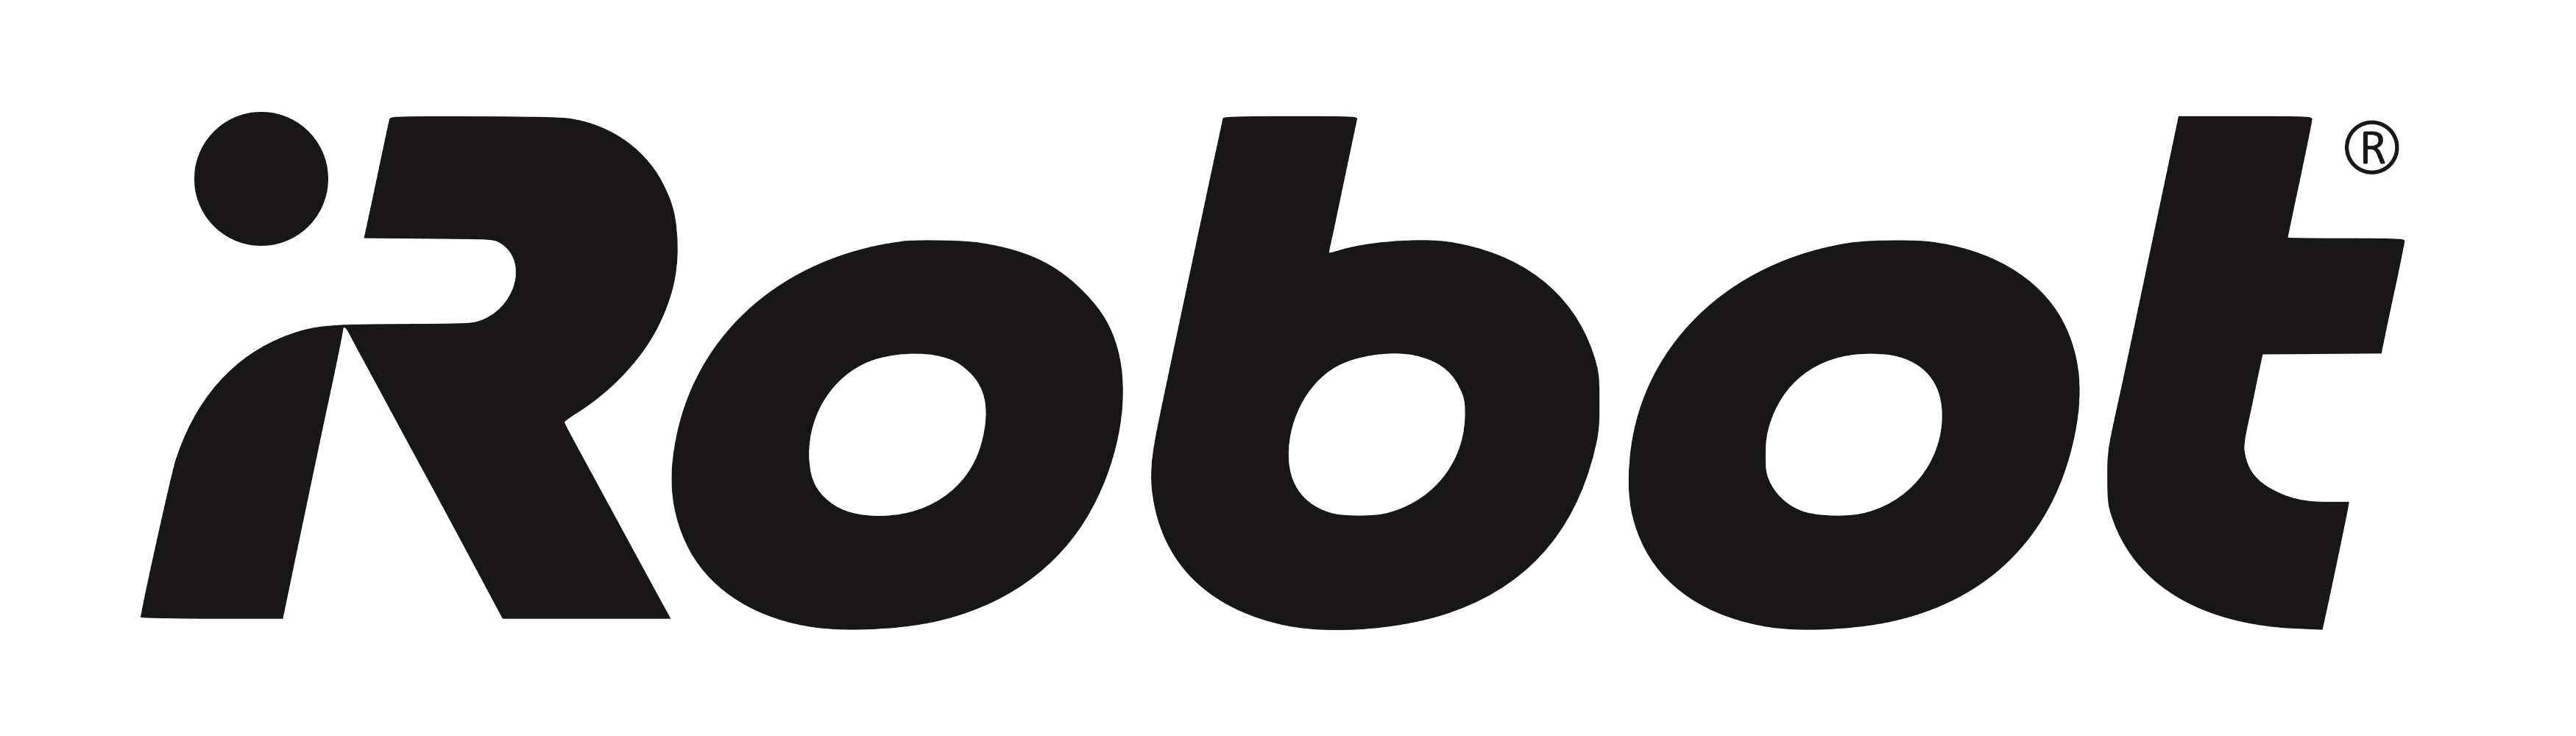

# iRobot Data Analyst Challege

[Tigran Melkonian](https://tigranmelkonian.github.io/webPage/ "Personal Webpage") - 12/19/2019

[Another cool project (using R)!😎](https://tigranmelkonian.shinyapps.io/celebrity_hype_dashboard/ "Celebrity_Hype_Dashboard")

## Notebook Overview
1. [Challenge Background](#Challenge-Background:)
2. [Data Overview](#Data-Overview🔎:)
3. [Exploratory Analysis](#Exploratory-Data-Analysis-and-visualization🤓:)
    * [Robot Mission Data](#Mission-Data-Exploration)
    * [Robot Geographic Data](#Geographic-Data-Exploration-🌎)
4. [Results 1: Geo Differences in robot usage](#1️⃣Part-one:-Analyzing-geographic-differences-in-robot-usage)
5. [Results 2: Inter-mission Intervals V.S. Mission Behavior](#2️⃣Part-two:-Calculating-inter-mission-intervals-and-relationships-between-other-features-of-robot-behavior)
6. [Results 3: Exploring Missing Data](#3️⃣Part-three-(BONUS):-Exploring-data-loss-among-the-mission-records)
7. [Conclusion](#Conclusion:)

## Challenge Background:

iRobot has a series of wifi-connected robotic vacuum cleaners available for sale worldwide. These robots are capable of autonomously navigating a home to vacuum its floors. Upon mission completion, they send a summary report of the mission to cloud services, where it is processed and stored as a row in a Postgres database. However, any cleaning mission performed while the robot is not connected to wifi (either by user's choice or a faulty connection) will not be saved in the database. In addition, there are occasional periods where cloud services malfunction and no missions are reported, resulting in discrete periods of data loss.

These robots are programmed with an automatic recharge and resume function, which means that when the robot detects its battery levels reaching critically low levels, it will navigate back to the charging dock if available and charge for up to 90 minutes before resuming the mission. In addition, if a robot becomes stuck on an obstacle in its environment or is manually paused by a button press, it will cease cleaning for up to 90 minutes before terminating the mission. If the user restarts the mission with a button press within 90 minutes of the pause, the robot will continue cleaning normally. The number of minutes spent cleaning, charging, or paused are reported for each mission, as is the mission outcome (a field describing whether the mission was cancelled, the robot got stuck, the battery died, or the robot completed the job successfully).

In this challenge, you're tasked to perform data analysis exploring use patterns of the typical robot user per country. Include relevant visualizations where appropriate, and address any possible effects of data loss on your findings.
1. Are there geographic differences in robot usage?
  - Consider all descriptive features of a mission, including when and how frequently it occurred.
  - If applicable, comment on how trends in these features might impact design decisions for the hardware, battery, or navigation algorithms of robots sold in different regions.
2. Calculate the time between consecutive missions for each robot ("inter-mission interval" or "IMI"). Describe any interesting relationships between IMI and other features of robot behavior.
3. **BONUS**: We are aware that data loss exists among the mission records, but are unsure of the cause. Quantify the extent of the loss, differentiating between discrete catastrophic events and random mission loss for individual robots. Investigate whether this loss is uniform or whether it may be impacting other analyses.

---

🎉🎉Now, it's time to have fun!🎉🎉

## Imports

#might have to run installation if plotly is not already installed
#conda install -c plotly plotly OR pip install plotly

In [1]:
import bz2
import numpy as np
import pandas as pd
import seaborn as sns
from os import listdir
import plotly.express as px
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt

## Data Overview🔎:

I have initialized a 'data' folder within my project folder that contains the provided geo_data and mission_data sets. Additionally, I have included an iso_mapping data set which will later be used to map country_cd to an ISO Alpha 2 code which will allow me to produce geo visualizations of robot mission features.

In [498]:
#Setting data dir path
DATA_PATH = '../iRobot_Homework/data'
listdir(DATA_PATH) #listing data dir contents

['geo_data.csv.bz2', 'iso_mapping.csv', 'mission_data.csv.bz2']

1. **mission_data.csv.bz2:**
This table contains details of cleaning missions for a sample of 10,000 wifi-connected robots
The columns are defined as follows:
 * **robotid**: a unique robot identifier (PRIMARY ID)
 * **datetime**: a date string that represents the start time of a mission in GMT
 * **nmssn**: mission number. This information comes from an internal counter on the robot that increments +1 per mission. Be aware that the complete mission history from mission 1 may not be included for each robot (due to missions being run before the robot was connected to wifi or data loss). The max mission number per robot should reflect its total number of missions to date reported to the database.
 * **runm**: this is the time in minutes that the robot spent actually cleaning.
 * **chrgm**: this is the time in minutes that a robot spent charging.
 * **pausem**: this is the time in minutes that a robot spent paused.
 * **outcome**: this is the end status of a mission. "Cncl" indicates that the mission was cancelled by the user. "Stuck" means the robot got stuck on an obstacle, and was not rescued within 90 minutes, so could not return to the dock. "Bat" means the robot's battery grew too low for it to return to the dock. "Ok" means the robot successfully completed cleaning the space and returned to the dock.

In [499]:
#Read in mission data from local data folder
mission_data = pd.read_csv(f'{DATA_PATH}/mission_data.csv.bz2', compression='bz2')
mission_data.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl


2. **geo_data.csv.bz2:**
This table contains details of the robot's geographic location.
The columns are defined as follows:
 * **robotid**: unique robot identifier (Foreign ID)
 * **country_cd**: 2-letter ISO country code
 * **timezone**: robot's timezone (from IANA/Olson database)

In [500]:
#Read in geo data from local data folder
geo_data = pd.read_csv(f'{DATA_PATH}/geo_data.csv.bz2', compression='bz2')
geo_data.head()

,country_cd,timezone,robotid
0,SE,Europe/Stockholm,T29NF13ZIYISNF79
1,JP,Asia/Tokyo,9S12V26O6G426OYR
2,IL,Asia/Jerusalem,QI6X3P9JKNILKKU1
3,IL,Asia/Jerusalem,7OMKNWMWA4XWC911
4,IL,Asia/Jerusalem,YO63CL0ZFK83SYCZ


3. **iso_mapping.csv:**
This table contains mapping data for on ISO Alpha 3 country names.
The columns are defined as follows:
 * **iso_alpha2**: 2-letter ISO country code
 * **iso_alpha3**: 3-letter ISO country code

In [501]:
#Read in geo mapping from local data folder - 
#mostly used for geo visualization of mission features
iso_mapping_data = pd.read_csv(f'{DATA_PATH}/iso_mapping.csv')
iso_mapping_data.head()

,country_cd,iso_alpha3
0,AF,AFG
1,AX,ALA
2,AL,ALB
3,DZ,DZA
4,AS,ASM


---

## Exploratory Data Analysis and visualization🤓:

To facilitate analyses in the long run, I decided to merge both mission_data and geo_data by robotid to create a new dataset called mission_data_full and then merged iso_mapping_data to append iso_alpha3 data for geo-visualizations. I will mainly be refering to this 'full' dataset throught the anlysis, however will address both mission_data and geo_data seperatly as needed (i.e. throughout missing data investigation).

In [502]:
#Left Join mission and geo data on unique identifier 'robotid' 
geo_data_full = pd.merge(geo_data,
                 iso_mapping_data,
                 on='country_cd') #CHECK TO MAKE SURE YOU ARE ACTUALLY LEFT JOINING

#Left join mission_data to newly created geo_data_full
mission_data_full = pd.merge(mission_data, 
                             geo_data_full, 
                             on = 'robotid')
mission_data_full.head(10)

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,iso_alpha3
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem,ISR
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem,ISR
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem,ISR
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem,ISR
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem,ISR
5,000Y9NBMJ77LQ7S7,2016-11-28 05:41:25,55,61,0,13,ok,JP,Asia/Tokyo,JPN
6,000Y9NBMJ77LQ7S7,2016-12-20 10:06:42,56,31,0,6,cncl,JP,Asia/Tokyo,JPN
7,000Y9NBMJ77LQ7S7,2017-02-18 03:16:40,57,11,0,2,cncl,JP,Asia/Tokyo,JPN
8,000Y9NBMJ77LQ7S7,2017-03-08 10:49:36,58,78,0,0,ok,JP,Asia/Tokyo,JPN
9,000Y9NBMJ77LQ7S7,2017-03-19 10:21:15,59,99,0,0,cncl,JP,Asia/Tokyo,JPN


In [503]:
#Number of unique robots in the dataset
num_unique_rbts = mission_data_full['robotid'].nunique()

print(f'There are {num_unique_rbts} robots observed in merged dataset')

There are 9826 robots observed in merged dataset


Date's always get converted to strings from CSV, so lets make sure we are working with real date objects..

In [504]:
#Lests see if features are assigned expected data types
mission_data_full.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 367679 entries, 0 to 367678
Data columns (total 10 columns):
robotid       367679 non-null object
datetime      367679 non-null object
nmssn         367679 non-null int64
runm          367679 non-null int64
chrgm         367679 non-null int64
pausem        367679 non-null int64
outcome       367679 non-null object
country_cd    367607 non-null object
timezone      367679 non-null object
iso_alpha3    367679 non-null object
dtypes: int64(4), object(6)
memory usage: 30.9+ MB


Was able to note that datetime was stored as string this is typical behavior from csv to dataframe..

In [505]:
#first convert datetime column to actual date object
mission_data_full['datetime']= pd.to_datetime(mission_data_full['datetime'])

In [506]:
#Calculate observation window of robot activity
obs_window = mission_data_full['datetime'].max() - mission_data_full['datetime'].min()
#view robot activity observation window as years
obs_window = round((obs_window.days / 365), 2)
print(f'The robot activity data was observed within {obs_window} years')

The robot activity data was observed within 1.99 years


In [507]:
#Number of unique countries 
unique_countries = mission_data_full['country_cd'].nunique()
print(f'The robot activity data was collected across {unique_countries} unique countries')

The robot activity data was collected across 84 unique countries


In [508]:
#Number of unique time zones
unique_timezones = mission_data_full['timezone'].nunique()
print(f'The robot activity data was observed within {unique_timezones} unique timezones')

The robot activity data was observed within 121 unique timezones


In [509]:
mission_data_full['outcome'].value_counts()

ok       190137
cncl     146615
stuck     22241
bat        8686
Name: outcome, dtype: int64

So, we have 9826 robots and they can each have 1 of the 4 outcomes with 91.6% likelyhood of either a successfull or user cancled mission, for each mission, shown above. 

In [510]:
mission_data_full.groupby(mission_data_full['datetime'].dt.date)['robotid'].nunique().mean()

368.6528925619835

In [511]:
mission_data_full.groupby(mission_data_full['datetime'].dt.year)['robotid'].nunique()

datetime
2015       1
2016    4798
2017    8114
Name: robotid, dtype: int64

We observe data from 368 robots on average a day. In 2016 we collected data from 4797 unique robots and that number jumped to 8114 in 2017. We should keep note of the growth of the robot population size within the two year time window to more accuratly make generalizations about robot mission behavior!

### Mission Data Exploration

I want to produce an at-a-glance dataframe view for mission_data_full. But before I do, I will create the Inter-mission interval ('imi') feature and append it to mission_data_full:

In [512]:
#Feature Engineering
#Calculate inter-mission intervals 'imi'
#appending intern-mission intervalas column to mission_data_full
mission_data_full['imi'] = mission_data_full.sort_values(['robotid','datetime']).groupby('robotid')['datetime'].diff()

#number of days since last mission between consecutive missions for each respective robot
#(as type float for easier analysis)
mission_data_full['imi'] = (mission_data_full['imi'].dt.days) + (mission_data_full['imi'].dt.seconds/86400)

#can run this line if you prefer to use minutes - warning: values in hundreds of thousands
#mission_data_full['imi'] = ((mission_data_full['imi'].dt.days * 86400) + (mission_data_full['imi'].dt.seconds))/60

#Construct summary stats df of mission data
nmssn_desc = pd.DataFrame(mission_data_full.groupby(['robotid'])['nmssn'].max())#rec method for extracting nmssn
mission_data_agg = mission_data_full.groupby(['robotid'])['runm', 'chrgm', 'pausem', 'imi'].mean()
mission_data_agg = pd.concat([nmssn_desc, mission_data_agg], axis=1) #joining into a summary stat table

#show summary stats
mission_data_agg.describe()

,nmssn,runm,chrgm,pausem,imi
count,9826.000000,9826.000000,9826.000000,9826.000000,9642.000000
mean,83.061062,49.113337,5.211029,6.276397,9.578643
std,39.307568,8.502607,3.306540,2.888759,19.569755
min,1.000000,0.000000,0.000000,0.000000,0.007994
25%,54.250000,44.805582,2.174702,4.536320,1.405040
50%,80.000000,49.372685,5.558258,6.387097,4.001283
75%,108.000000,53.598438,7.571429,8.034483,9.797152
max,248.000000,112.000000,29.000000,29.000000,427.138299


To get a quick sense of how mission features are distributed across the 9826 robots I will generate a set of
simple frequency distribution plots.

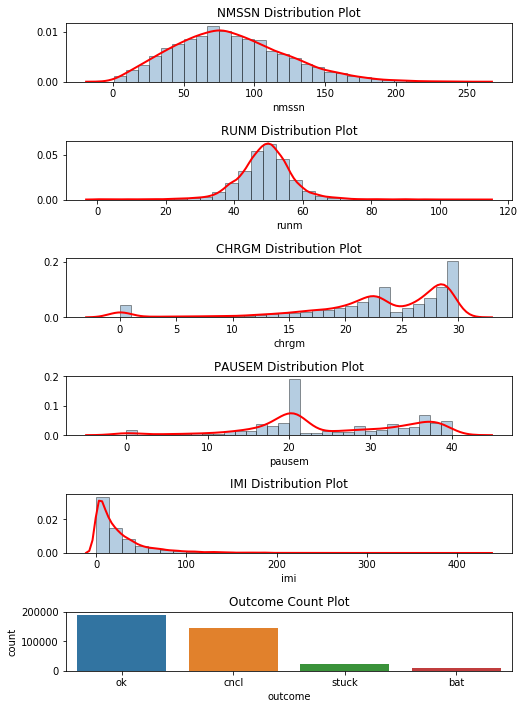

In [515]:
#Density Plot and Histogram of all 

#Setting subplot matrix for dist plots bellow
dist_fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, figsize=(8,9))
dist_fig.subplots_adjust(bottom= 1, top = 2, wspace = .2, hspace = 1)

#NMSSN distribution plot 
nmssn_plt=sns.distplot(mission_data_full.groupby(['robotid'])['nmssn'].max(), hist=True, kde=True, 
             bins=30, color = 'steelblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2, "color": "red"}, ax=ax1).set_title('NMSSN Distribution Plot')

#RUNM distribution plot 
runm_plt=sns.distplot(mission_data_full.groupby(['robotid'])['runm'].mean(), hist=True, kde=True, 
             bins=30, color = 'steelblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2, "color": "red"}, ax=ax2).set_title('RUNM Distribution Plot')

#CHRGM distribution plot 
chrgm_plt=sns.distplot(mission_data_full.groupby(['robotid'], sort=False)['chrgm'].max(), hist=True, kde=True, 
             bins=30, color = 'steelblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2, "color": "red"}, ax=ax3).set_title('CHRGM Distribution Plot')

#PAUSEM distribution plot 
pausem_plt=sns.distplot(mission_data_full.groupby(['robotid'], sort=False)['pausem'].max(), hist=True, kde=True, 
             bins=30, color = 'steelblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2, "color": "red"}, ax=ax4).set_title('PAUSEM Distribution Plot')

#IMI distribution plot 
imi_plt=sns.distplot(mission_data_full.groupby(['robotid'], sort=False)['imi'].max(), hist=True, kde=True, 
             bins=30, color = 'steelblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2, "color": "red"}, ax=ax5).set_title('IMI Distribution Plot')

#OUTCOME distribution plot 
outcome_plt = sns.countplot(x="outcome", data= mission_data_full, order = mission_data_full['outcome'].value_counts().index).set_title('Outcome Count Plot')


**Number of missions:** 
* I can note from the histogram plots above that nmssn depicts a left-skewed, positive distribution. There is a concentration of data among a shorter number of completed missions and a long tail to the right. The data seems to be centered around 50 - 100 with a few exceptions that are distributed along a relatively short range of higher complete missions. It is important to note that this implies that roughly half of the robots have recorded 80 missions with an average of 83 missions. The data ranges from 0 to 248 missions. 
  
**Number of minutes spent cleaning:**
* I can note from the histogram plots above that runm depicts a normal distribution with mean (49.1) ~= median (49.4) and comparable tails on either end. There exists a main concentration of data at a 55-108-minute range, and a short tail to the right. There are a few exceptions that are distributed along a relatively short range of longer missions. Roughly half of the robots spend 49 minutes per mission. The data ranges from 0 to 144 minutes. User interference with a robot’s mission, i.e. the user pauses the robot during a mission once or multiple times, may explain why a lot of missions last longer than 55-108 minutes.

**Number of minutes spent charging:**
* I can note that chrgm depicts a bimodal distribution that is strongly skewed to the left (negatively skewed). There exist two separate concentrations of chargm a smaller peak at approximately 22.5 minutes and a larger peak at 28.5 minutes with a long tail to the left. These are different groups of robot mission charging behavior. It could be that one group spends less time charging because they experience more user mission interference (more pausem or users preventing robot to achieve a full charge) and the other group is allowed to carry out its automated behavior and only charges once battery levels have reached a critical level and is allowed a full charge prior to embarking on the next mission. There also exists a noteworthy concentration of pausem that was reported as 0 which is a a favorable outcome for an automated system. Most of the data seems to be centered around 0 - 15 minutes. It is important to note that roughly half of the robots spend 5 minutes charging after each mission. The low average and noteworthy concentration of 0 chrgms makes sense because we should expect a robot’s battery charge to last for multiple missions before it requires another charge. The data ranges from 0 to 29 minutes.

**Number of minutes spent paused:**
* I can note from the histogram plots above that pausem depicts a bimodal distribution that 
  is strongly skewed to the left (negatively skewed). There exist two separate concentrations of pausem among a larger peak at approximately 21-22 minutes and a smaller peak at approximately 35-38 minutes. These are different groups of robot mission pausing behavior. Similar to the charging behavior explained above, it could be that one group spends more time paused because they experience more user mission interference and the other group is allowed to more freely carry out its automated behavior and is physically paused less often. There also exists a noteworthy concentration of chrgm that was reported as 0.The majority of the data seems to be centered around 0 - 15 minutes. Roughly half of the robots spend 6.38 minutes paused throughout a mission. So, unless a user interferes with their robot’s mission, the robot should either be charging or completing a mission. The data ranges from 0 to 40 minutes. 
  
**Inter-mission Intervals:**
* I can note that 'imi' depicts a unimodal distribution that is strongly skewed to the right (negatively skewed). There exists a main concentration of 'imi' within the 0 – 40 day range, and a very long tail to the right. 'imi' ranges from 0 to 427 days (seems like somebody found their long-lost robot!) Roughly half of the robots are inactive for 4 days in between consecutive missions (reasonable cleaning schedule).  


**Mission Outcome:**
* I can note that the vast majority of outcomes were reported as either 'ok' or 'paused', meaning that 91.6% of all mission outcomes result in 'ok' indicating a successful mission or have been interrupted by the user pausing their robots where I believe it’s safe to consider partially successful (innocent until proven guilty... successful unless explicitly proven as system failure).


Understanding behavioral relations that could explain unfavorable mission outcomes: 'bat' and 'stuck'

In [516]:
#summary mission states for bat and stuck categories
runm_diff_bat_ok = mission_data_full[mission_data_full.outcome == 'bat']['runm'].mean() - mission_data_full[mission_data_full.outcome == 'ok']['runm'].mean()
runm_diff_bat_cncl = mission_data_full[mission_data_full.outcome == 'bat']['runm'].mean() - mission_data_full[mission_data_full.outcome == 'cncl']['runm'].mean()
runm_diff_bat_stuck = mission_data_full[mission_data_full.outcome == 'bat']['runm'].mean() - mission_data_full[mission_data_full.outcome == 'stuck']['runm'].mean()

print(f'Average mission runtime difference between "bat" and "ok" outcomes is {round(runm_diff_bat_ok,2)} minutes!\n')
print(f'Average mission runtime difference between "bat" and "cncl" outcomes is {round(runm_diff_bat_cncl,2)} minutes!\n')
print(f'Average mission runtime difference between "bat" and "stuck" outcomes is {round(runm_diff_bat_stuck,2)} minutes!\n')


Average mission runtime difference between "bat" and "ok" outcomes is 10.86 minutes!

Average mission runtime difference between "bat" and "cncl" outcomes is 10.14 minutes!

Average mission runtime difference between "bat" and "stuck" outcomes is 59.47 minutes!



The differences above make sense to intuitive guess as to why bat outcome occures. On average missions that result in a bat outcome are operating for 10.86 minutes longer than a successful run that would result in an 'ok' outcome. This is fairly in line with the average difference between bat and cncl outcomes. The relatively large difference between a 'bat' outcome and a 'stuck' outcome makes sense becuse

Due to the automation of vacuum units, we can expect the robots to follow built in navigation algorithms. By removing most of human interaction from the vacuuming process, it is safe to say that the robots will perform the same no matter where you use it in the world. It might be worth to optimize the navigation algorithm further so that it is less likely to get stuck for > 90 minutes and terminate a mission (a catastrophic failure). A better navigation algorithm will result in more normal missions and further reduce human interaction (i.e. cancling a mission). The navigation algorithm is a robot’s main limitation to optimal functionality. Taken into consideration both the average number of missions within a day and the average runtime per mission we can determine how many missions the robot is able to complete before requiring a recharge. An runtime of 74.6 minutes per mission seems too long for optimal battery conservation. An upgrade in the robot’s hardware would be ideal so that it performs faster and is more efficient with battery consumption. There is room for improvement for average mission runtime that can be overcome with hardware upgrades and optimization of the navigation algorithm. 

Next, I would like to subset varying mission behavior groups discussed above to investigate potential difference in behavior among robots that have both chrgm < 24 and pausem < 22.5 and chrgm > 24 and pausem > 22.5 and compare against summary stats for the entire mission data set that is presented above. 


In [517]:
#setting behavioral subset of mission_data_full
mission_data_full_behavior1 = mission_data_full[(mission_data_full.chrgm <= 24) & (mission_data_full.pausem <= 22.5)]
mission_data_full_behavior2 = mission_data_full[(mission_data_full.chrgm > 24) & (mission_data_full.pausem > 22.5)]

In [519]:
#Creating agg data set for behavior1 set
nmssn_desc_behavior1 = pd.DataFrame(mission_data_full_behavior1.groupby(['robotid'])['nmssn'].max())#rec method for extracting nmssn
mission_data_agg_behavior1 = mission_data_full_behavior1.groupby(['robotid'])['runm', 'chrgm', 'pausem', 'imi'].mean()
mission_data_agg_behavior1 = pd.concat([nmssn_desc_behavior1, mission_data_agg_behavior1], axis=1) #joining into a summary stat table

#show summary stats for behavior 1
mission_data_agg_behavior1.describe()

,nmssn,runm,chrgm,pausem,imi
count,9819.000000,9819.000000,9819.000000,9819.000000,9636.000000
mean,83.057542,47.679801,4.226321,5.159859,9.543756
std,39.295606,8.574978,2.629746,2.180162,19.642093
min,1.000000,0.000000,0.000000,0.000000,0.008169
25%,54.000000,43.251316,2.088562,4.154196,1.391031
50%,80.000000,47.734513,4.269231,5.283019,3.978622
75%,108.000000,52.000000,5.916667,6.304348,9.728920
max,248.000000,111.000000,22.000000,22.000000,427.138299


In [520]:
#Creating agg data set for behavior1 set
nmssn_desc_behavior2 = pd.DataFrame(mission_data_full_behavior2.groupby(['robotid'])['nmssn'].max())#rec method for extracting nmssn
mission_data_agg_behavior2 = mission_data_full_behavior2.groupby(['robotid'])['runm', 'chrgm', 'pausem', 'imi'].mean()
mission_data_agg_behavior2 = pd.concat([nmssn_desc_behavior2, mission_data_agg_behavior2], axis=1) #joining into a summary stat table

#show summary stats for behavior 2
mission_data_agg_behavior2.describe()

,nmssn,runm,chrgm,pausem,imi
count,1805.000000,1805.000000,1805.000000,1805.000000,1755.000000
mean,72.803324,57.291062,26.914423,36.028753,5.709007
std,35.640926,11.789452,1.327649,1.808235,10.621174
min,2.000000,41.000000,25.000000,33.000000,0.000046
25%,47.000000,46.000000,26.000000,34.666667,0.796406
50%,71.000000,56.500000,27.000000,36.000000,2.250671
75%,95.000000,69.000000,28.000000,37.333333,6.087888
max,202.000000,75.000000,30.000000,40.000000,137.531007


Comparing across all three summary stat tables, I can note that the first behavior group with chrgm <= 24 and pausem <= 22.5 fall inline with the overall summary stat results described above because the vast majority of observations (93%) follow behavior1. However the second behavioral group with chrgm > 24 and pausem > 22.5 , making up a total of 7% of the toal observations, expereinces a decrease in number of overall missions and inter-mission intervals and an increase in average runm. Thinking through this, robots that exhibit behavior2 on average compared against the overall data set complete ~10 less missions, spend ~4 less days on average in an inactive state inbetween missions, and run ~10 minutes longer. If provided more time I would have been able to dig further into visualizing  geographic differences between the overall mission data set and the behavior2 data set. 

### Geographic Data Exploration 🌎

In [521]:
#Creating country level mission feature aggregates dataframe
nmssn_agg = pd.DataFrame(mission_data_full.groupby(['robotid', 'iso_alpha3'])['nmssn'].max()).groupby(['iso_alpha3'])['nmssn'].mean()
mssn_agg = mission_data_full.groupby(['iso_alpha3'])['runm', 'chrgm', 'pausem', 'imi'].mean()
mission_data_cntry_agg = pd.concat([nmssn_agg, mssn_agg], axis=1)
mission_data_cntry_agg.index.name = 'iso_alpha3'
mission_data_cntry_agg.reset_index(inplace=True)
mission_data_cntry_agg.head(10)

,iso_alpha3,nmssn,runm,chrgm,pausem,imi
0,AND,82.000000,40.020000,1.500000,2.000000,0.174693
1,ARE,90.000000,50.623810,1.928571,4.214286,5.579302
2,ARG,78.375000,49.242830,1.988528,5.204589,5.579114
3,ATG,72.000000,51.625000,3.125000,7.750000,0.299345
4,AUS,78.744186,48.036129,1.971290,4.599355,4.444997
5,AUT,84.957895,47.184978,1.930100,4.572362,4.346155
6,AZE,69.000000,44.547619,1.523810,3.738095,1.501392
7,BEL,87.406015,47.606090,2.094085,4.697833,4.459877
8,BGR,68.250000,51.312057,2.099291,5.468085,7.616692
9,BHR,61.000000,43.625000,0.625000,5.750000,26.807594


In [522]:
mission_data_cntry_agg.describe()

,nmssn,runm,chrgm,pausem,imi
count,85.000000,85.000000,85.000000,85.000000,84.000000
mean,85.145670,47.219755,2.027243,4.708117,4.473327
std,19.085318,4.596105,0.731815,0.896464,3.837346
min,37.000000,21.000000,0.000000,0.696210,0.023609
25%,78.744186,45.282609,1.839130,4.456800,2.898910
50%,84.949153,47.450038,1.943243,4.658667,4.024349
75%,91.333333,49.406631,2.112520,4.940443,4.867626
max,141.000000,59.520000,7.200628,7.750000,26.807594


It is easy to note from the geovisualization bellow how mission count is distributed among countries at a mean of 85.66 missions. Theres an greater density of robot locations centered throughout Europe and the Middle East.  

In [523]:
#Geo-visualization for mission features
#Alter visualization by changing size to =  'runm', 'pausem', 'chrgm', 'nmssn' (shown by default)
nmssn_scatter_fig = px.scatter_geo(mission_data_cntry_agg, 
                     locations="iso_alpha3",
                     size="nmssn", # size of markers
                     color = 'iso_alpha3',
                     projection="natural earth")
nmssn_scatter_fig.show()

In [524]:
#Creating country level robot counts to understand distribution of observed mission data
rbt_cntry_cnt = pd.DataFrame(mission_data_full.groupby('iso_alpha3')['robotid'].nunique())
rbt_cntry_cnt.index.name = 'iso_alpha3'
rbt_cntry_cnt.reset_index(inplace=True)
rbt_cntry_cnt = rbt_cntry_cnt.rename(columns = {"robotid":"robot_cnt"})
rbt_cntry_cnt.sort_values(by=['robot_cnt'], inplace=True, ascending = False)

#Summary statistics for robots per country 
rbt_cntry_cnt.head(10)

,iso_alpha3,robot_cnt
41,ISR,5956
17,CHN,539
28,FRA,481
44,JPN,293
5,AUT,285
14,CAN,277
81,USA,237
22,DEU,208
7,BEL,133
62,POL,119


---

#### **1️⃣Part one: Analyzing geographic differences in robot usage**

Upon further exploration, I have discovered that the mean number of robots per country is 119. Only 10 countries including(IL, CN, FR, JP, CA, AT, DE, US, BE, NO) have a robot count that is greater than or equal to the mean number of robots. Approximatly 93% of mission data is generated from only 20 countries including: (in order from greatest number of robots to least) IL, CN, FR, JP, CA, AT, DE, US, BE, NO, PL, IT, TW, RU, AU, CZ, ES, NL, DK, CH. Israel (IL) alone makes up for approximately 60% of all mission data through 5956 robots. China comes in at very distant second place, making up for approximately 6% of all mission data through 539 robots.  75% of all countries observed have less than 100 robots.

The geo visualization below provides a great view to help understand this discrepancy in unique number of robots reporting mission data. 

In [465]:
#Geo-visualization for robot counts
rbt_cnt_scatter_fig = px.scatter_geo(rbt_cntry_cnt, 
                     locations="iso_alpha3",
                     size="robot_cnt", # size of markers
                     color = 'iso_alpha3',
                     projection="natural earth")
rbt_cnt_scatter_fig.show()

Aside from differences in the number of robots in reporting mission data from each of the 84 unique countries, the country level summary statistics and visualizations of mission behavior detailed above doesn't signal any significant variation in robot usage dependent on geographical location. On an intuitive level, the lack of diversity in mission behavior across countries makes sense because the robots' behavior is automated. User interaction is limited and there exists a reduced degree of variation in user/product interaction. I would say that the lack of difference in behavior should be looked at, from iRobot's perspective, as a great testimant to the effectiveness of automation built-in their robots. I would have loved to dig further into identifying which countries the robots that exhibited behavior2 are located in. 

#### **2️⃣Part two: Calculating inter-mission intervals and relationships between other features of robot behavior**

Before I was able to calculate the inter-mission intervals (IMI) for each robot, I had to
sort mission_data by date and robotid so that I only calculate positive IMI’s while maintaining each robotid’s respective data grouping. After, I merged imi to mission_data_full. click here to go back to the code that generates 'imi' for reference.

In [527]:
#significant decrease in imi over the year
mission_data_full.groupby(mission_data_full['datetime'].dt.month)['imi'].mean()

datetime
1     5.489855
2     5.136291
3     5.040233
4     5.097134
5     5.063511
6     4.767499
7     4.821599
8     4.462293
9     4.336845
10    4.021745
11    3.416880
12    2.928546
Name: imi, dtype: float64

Inter-mission intervals average out to about 5.5 days at the start of the year and then taper down to 2.9 days at he end of the year. This is a great raw visualization to better understanding the sesonality of robot activity. As the year progresses the rate at which robots carry out a missions increases fairly linearly.  

In my opinion, a heatmap is the best way to get a quick overview of all mission features and their relationships with one another.

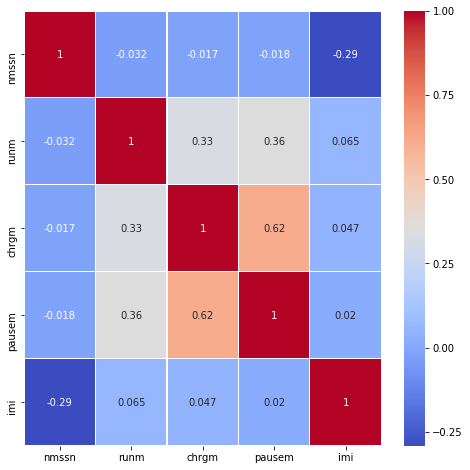

In [526]:
f,ax = plt.subplots(figsize=(8, 8))
#setting correlation df (runn 'corr' if you just want corr plot)
corr = mission_data_agg.corr()
#producing heatmap
mission_data_corr = sns.heatmap(corr, annot=True,cmap='coolwarm', linewidths=.2,ax=ax)

At first sight, from the correlation plot below we can note that the IMI feature is fairly negatively correlated with nmssn. Meaning that there exists a relatively strong relation between the two where IMI increases and nmssn decreases (explainig a total of 8.4 % of the variation in nmssn measure). This intuitively makes sense because the less time the robot is inactive the more missions there will be recorded in any given timeframe. Though the correlation is weak I would think that this is one of the rare moments a causal relationship exists among behavioral features that just makes sense. On average each robot is inactive for 9.57 days in between consecutive missions. Other than nmssn, there are non-significant positive correlations with pausem, chrgm, and runm. Meaning that as IMI increases, so do the other three variables and vice versa. However, these correlations are too weak to conclude a significant relation. 

Taking correlation to the next level with regression analysis..

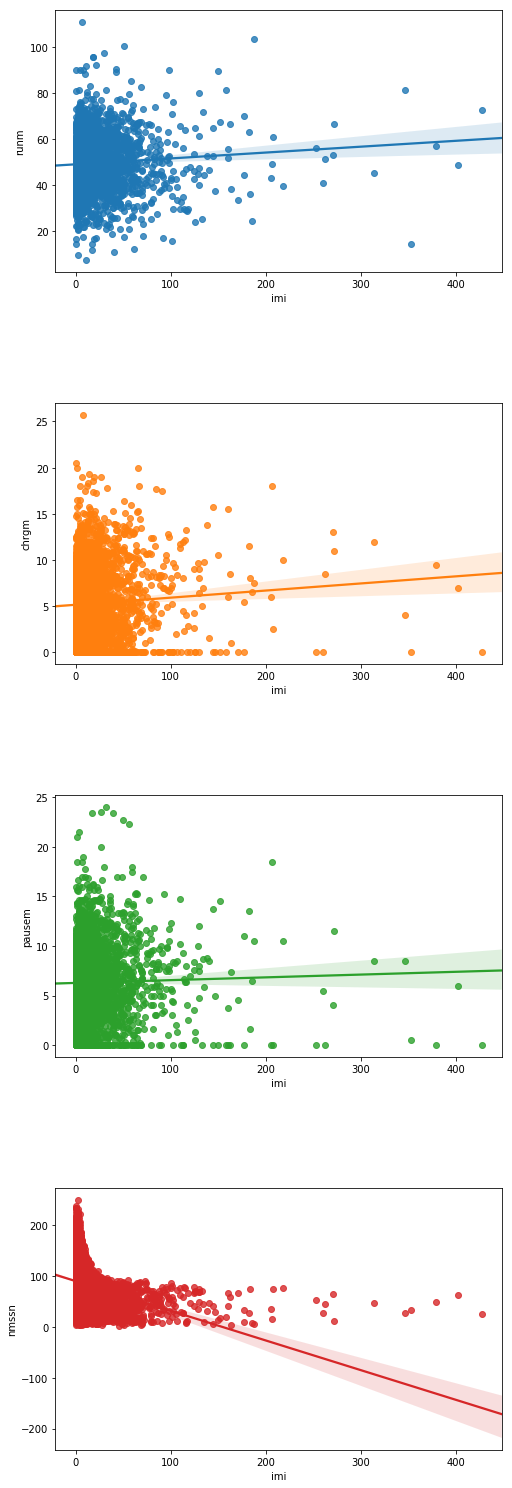

In [96]:
#Setting subplot matrix for dist plots bellow
lm_fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(8,20))
lm_fig.subplots_adjust(bottom= 1, top = 2, wspace = .2, hspace = .5)
#Data is too large, sampling data to more quickly produce regplots w/ ci - still takes a while
#sample_data = mission_data_full.sample(frac = .25)
# regression plots with imi as outcome variable
imi_runm_reg = sns.regplot(data=mission_data_agg, x="imi", y="runm", ax = ax1)
imi_chrgm_reg = sns.regplot(data=mission_data_agg, x="imi", y="chrgm", ax = ax2)
imi_pausem_reg = sns.regplot(data=mission_data_agg, x="imi", y="pausem", ax = ax3)
imi_nmssn_reg = sns.regplot(data=mission_data_agg, x="imi", y="nmssn", ax = ax4)

Refrencing the regression plots above we can further drive home the weak correlations between imi and pausem, runm, and chrgm. The last regression plot that depicts the relation between imi and nmssn is quite interesting. The relation seems homoscedastic because the points remain concentrated throughout the 0-100 nmssn range no matter the imi, meaning the random disturbance in the relationship between the variables is the same across all values of the independent variables. This phenomenon can also be as a result of the data collection period. There are so many missions on average a robot can complete throughout a two year time span and it appears that the range is 0-100. 

#### **3️⃣Part three (BONUS): Exploring data loss among the mission records**

###### Missing Data:  
😱😱😱😱😱😱😱😱
* Quantify the extent of the loss, differentiating between discrete catastrophic events and random mission loss for individual robots.

* Investigate whether this loss is uniform or whether is random, in which case it may be impacting the analyses.

The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from producing reliable analyses. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hidding an inconvenient truth.

**Random errors** in measurements are caused by unknown and unpredictable changes throughout a robot's mission. These changes usually result from environmental conditions but may occur in the robot's measuring instruments. Random errors often have a Gaussian normal distribution. In such cases statistical methods may still be used to analyze the data. On the other hand **systematic errors** usually come from the measuring instruments or EXCEPTIONALY poor enviromental conditions. They may occur because: there is something wrong with the robot or its data collection system, or because the robot is wrongly used by the owner. Some examples of how it may affect the data and prevent reliable analyses (unless accounted for) are as follows: zero setting error in which the robot does not propperly collect data throughout an entire mission or set of missions, and 
multiplier or scale factor error in which the robot consistently collects data that is measured greater or less than the actual changes.

Within geo_data there exist 10,000 unique robotids, however there are only 9826 unique robotids in
mission_data. So, it is quite possible that there exist 174 unique missing robot mission data sets. Lets take a look at where these robots are located.

In [532]:
#Subset geo_data that does not match to ANY mission data
missing_mssn_data = geo_data_full[(~geo_data_full.robotid.isin(mission_data.robotid))]
missing_mssn_data_cnt = pd.DataFrame(missing_mssn_data.groupby('iso_alpha3')['robotid'].nunique())
missing_mssn_data_cnt.index.name = 'iso_alpha3'
missing_mssn_data_cnt.reset_index(inplace=True)
missing_mssn_data_cnt = missing_mssn_data_cnt.rename(columns = {"robotid":"robot_loss_cnt"})
missing_mssn_data_cnt

,iso_alpha3,robot_loss_cnt
0,AUS,1
1,AUT,8
2,BEL,2
3,BRA,1
4,CAN,5
5,CHE,1
6,CHN,7
7,CZE,1
8,DEU,4
9,FRA,6


Note from above that there exist 26 unique countries that have robots which did not report mission data. The average number of robots per country, without taking into consideration Israel, is 2.6. Isreal is far above this mean indicating that this loss may be systematic where measuring instruments could have failed to properly observe and collect mission data. 62.6 percent of all missing
mission_data comes from Israel. All other countries that have missing robot data each make
up for less than five percent of all missing data and still would be categorized as random loss. Lets control for the number of robots in a given country to get the rate of loss

In [533]:
data = pd.merge(missing_mssn_data_cnt, 
                rbt_cntry_cnt, 
                on = 'iso_alpha3')
data['loss_rate'] = data.robot_loss_cnt / (data.robot_cnt + data.robot_loss_cnt)
data

,iso_alpha3,robot_loss_cnt,robot_cnt,loss_rate
0,AUS,1,86,0.011494
1,AUT,8,285,0.027304
2,BEL,2,133,0.014815
3,BRA,1,35,0.027778
4,CAN,5,277,0.017730
5,CHE,1,49,0.020000
6,CHN,7,539,0.012821
7,CZE,1,59,0.016667
8,DEU,4,208,0.018868
9,FRA,6,481,0.012320


Surprisingly it seems like the percentage of loss per country is normally distributed. It seemed like Isreal had way to many robots that were not collecting and reporting mission data, however when we controled for number of robots in the country, we can easily note that the loss rate ratio follows a normal distribution with respect to relative number of robots. 

In [534]:
data.describe()

,robot_loss_cnt,robot_cnt,loss_rate
count,26.000000,26.000000,26.000000
mean,6.692308,358.192308,0.051407
std,20.975737,1150.642013,0.096342
min,1.000000,1.000000,0.004202
25%,1.000000,25.750000,0.016695
50%,1.000000,106.000000,0.025226
75%,4.000000,229.750000,0.039091
max,109.000000,5956.000000,0.500000


Next, I want to investigate whether there were any records of robots incrementing mission data but failing to record all mission features: runm, pausem, and chrgm and wether a specific outcome type or country was responisble for this phenomenon that intuitively seems to be a clear cut case of system data collection faliure or loss of WiFi connectivity. 

In [535]:
data = mission_data_full[(mission_data_full['runm'] == 0) & (mission_data_full['pausem'] == 0) & (mission_data_full['chrgm'] == 0)]


In [536]:
data['outcome'].apply(lambda x: x).value_counts()

stuck    9867
cncl     2780
ok        209
bat        31
Name: outcome, dtype: int64

We can easily note that the mission outcome most responsible for this anomaly is 'stuck' at 9867 observations. Second is 'cncl' which intuitively makes sense because a robot can start a mission but hace the mission cancled almost immediatly (within one minute) by the user for any reason. The 'bat' outcome is the another outcome responsible for this anomaly that makes sense because the robot might have started a mission with low battery and then depleted entierly within the minute threshold before runm is able to be incremented by data collection system. Let's now dive deeper into beter understanding this anomaly in junction with the 'stuck' outcome

In [537]:
#subsetting data for outcome of 'stuck'
data = data[(data['outcome'] == 'stuck')]
data.head(5)

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,iso_alpha3,imi
54,00EZQ4MZ6JLQPJK6,2016-07-06 06:00:00,78,0,0,0,stuck,FR,Europe/Paris,FRA,1.473009
92,00EZQ4MZ6JLQPJK6,2016-10-01 22:00:19,126,0,0,0,stuck,FR,Europe/Paris,FRA,1.676829
94,00EZQ4MZ6JLQPJK6,2016-10-08 10:00:00,128,0,0,0,stuck,FR,Europe/Paris,FRA,4.737616
99,00KI1HU70Y15Z10K,2017-01-14 18:56:16,79,0,0,0,stuck,BE,Europe/Brussels,BEL,3.349965
118,00KI1HU70Y15Z10K,2017-06-25 09:33:32,103,0,0,0,stuck,BE,Europe/Brussels,BEL,5.952905


In [545]:
#average number of times this happens per robot - indicates system faliure
robots_failed = pd.DataFrame(data.groupby('robotid')['outcome'].count())
#num robots
#robots_failed.count()
#avrge number of fails
#robots_failed.mean()

Out of 9826 robots observed in mission data, 4660 robots have expereinced this anomolous behavior at an average of 2.12 occurences that resulted in an outcome of 'stuck'. 95 % of all robots have less than 6.3 occurences that resulted in an outcome of 'stuck'. This can therefore be accounted as norrandommal loss. Now, lets shift our focus to missing data in mission_data_full. 

In [546]:
mission_data_full.isnull().sum(axis = 0)

robotid          0
datetime         0
nmssn            0
runm             0
chrgm            0
pausem           0
outcome          0
country_cd      72
timezone         0
iso_alpha3       0
imi           9826
dtype: int64

Let's analyse this to understand how to handle the missing data. There are 72 missions where country_cd was not reported. Lets now shine light on these robots and understand where they might be from and from how many unique robots. Imi has 1 NA for each unique robot in mission_data_full because the earliest observation date has no lag. I figured it was better to leave as NA so lack of earlier dates wont bring affect analyses. No action is necessary for these NA's. 

In [547]:
missing_mssn_data = mission_data_full[mission_data_full.country_cd.isnull()]
missing_mssn_data.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone,iso_alpha3,imi
272312,QMJXZLREE88GULA1,2016-01-16 17:51:43,69,75,0,16,ok,NaN,Europe/Vaduz,NAM,NaN
272313,QMJXZLREE88GULA1,2016-03-27 01:30:16,70,68,0,15,ok,NaN,Europe/Vaduz,NAM,70.318438
272314,QMJXZLREE88GULA1,2016-04-08 09:31:33,71,60,0,0,ok,NaN,Europe/Vaduz,NAM,0.086782
272315,QMJXZLREE88GULA1,2016-04-08 07:26:35,72,58,0,12,ok,NaN,Europe/Vaduz,NAM,12.247442
272316,QMJXZLREE88GULA1,2016-04-25 06:13:15,74,68,0,0,bat,NaN,Europe/Vaduz,NAM,16.862292


In [548]:
missing_mssn_data['robotid'].nunique()

2

In [549]:
missing_mssn_data.groupby(['robotid'])['robotid'].count()

robotid
QMJXZLREE88GULA1    47
Z9JJM7JRIGJYLER2    25
Name: robotid, dtype: int64

the 72 missions where contry_cd was not reported resulted from 2 unique robots in seperate timezones ('Europe/Vaduz' and 'Africa/Windhoek') with one robot failing to report country_cd on 47 mission and the second failing to report country_cd on 25 missions. This can be explained by loss of WiFi connection since WiFi is presumably necessary for collecting geolocation information of a robot. To validate this claim, I would like to see if these two robots  have any missions with successfull data collection. 

In [365]:
#Length of mission_data_full subset where robot id is either of the two robots 
#that failed to report country_cd on multiple consecutive missions

mission_data_mssng_subset = mission_data_full[(mission_data_full.robotid == 'QMJXZLREE88GULA1') |(mission_data_full.robotid == 'Z9JJM7JRIGJYLER2')]
len(mission_data_mssng_subset)

72

(Aha!) These two robots have not sucessfully reported countr_cd. But that still does not explain why they were still able to measure and report other mission features. Two possible explinations: either lack of WiFi connectivity or the measuring tool/system of these robots used to report geolocation is faulty. In both cases I would categorize this as catestrphic systematic loss. Though this does not necesarily affect my analyses, because these events constitute such a small sample of all mission observations. Nevertheless, I believe we should further investigate for hardware
malfunction such as a malfunctioning Wi-Fi connector. 

## Conclusion:

That's it! We reached the end of our exercise!

Hi Angela (I hope you got the chance to review this),

I thoroghly enjoyed attempting to answer your defined objectives and hope I've done your well thought out and fun assignment justice! My appologies for a submission on the due date of the assignment, this past week has been hectic because of the upcomming holidays and I tried to dedicate as much time to the assignment as possible. I believe it was a great real-world exercise that provided an in-depth glimpse into the iRobot's data the type of analytic work can I expect within the data science team at iRobot. I look forward to hearing back from you with feedback and am hoping to connect with you in the near future to further discuss a role within the data science team that you believe best fits my current expereince level and skill set. Thank you for your time and consideration! 

Best, 
Tigran